In [1]:
import os
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling
from skimage.transform import resize
   
# Directory containing subdirectories with B04.tif images
input_directory = "/kaggle/input/cloud-cover-detection/data/train_features"

# Directory containing label tif images with subdirectory names
label_directory = "/kaggle/input/cloud-cover-detection/data/train_labels"

# Initialize lists to store resized images and labels
resized_images = []
resized_labels = []

# Iterate through subdirectories
for subdir in os.listdir(input_directory):
    subdir_path = os.path.join(input_directory, subdir)
    if os.path.isdir(subdir_path):
        # Check if B04.tif exists in the subdirectory
        b04_path = os.path.join(subdir_path, 'B04.tif')
        if os.path.exists(b04_path):
            # Read and resize B04.tif using rasterio
            with rasterio.open(b04_path) as src:
                data = src.read(1, out_shape=(1, 64, 64), resampling=Resampling.bilinear)
                transform = src.transform * Affine.scale(1.0 / src.width, 1.0 / src.height)
                resized_images.append(data)

            # Read and resize label image using rasterio
            label_path = os.path.join(label_directory, f'{subdir}.tif')
            if os.path.exists(label_path):
                with rasterio.open(label_path) as label_src:
                    label_data = label_src.read(1, out_shape=(1, 64, 64), resampling=Resampling.bilinear)
                    label_transform = label_src.transform * Affine.scale(1.0 / label_src.width, 1.0 / label_src.height)
                    resized_labels.append(label_data)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
images=np.array(resized_images)
labels=np.array(resized_labels)

In [26]:
labels=np.array(resized_labels)

In [5]:
images.shape


(11748, 64, 64)

In [22]:
labels.shape

(11748, 64, 64)

In [3]:
images=images.reshape(images.shape[0],images.shape[2],images.shape[1],1)

In [27]:
labels=labels.reshape(labels.shape[0],labels.shape[2],labels.shape[1])

In [9]:
images.shape

(11748, 64, 64, 1)

In [24]:
labels.shape

(11748, 64, 64)

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a more complex ViT model with heads for image segmentation
def create_complex_vit_with_heads(image_shape, num_classes, num_heads):
    inputs = tf.keras.layers.Input(shape=image_shape)  # Assuming 3 channels for RGB images

    # Flatten the input
    x = layers.Flatten()(inputs)

    # Define heads
    heads = []
    for _ in range(num_heads):
        # Add multiple Dense layers with ReLU activation and Batch Normalization
        head = layers.Dense(1024, activation="relu")(x)
        head = layers.BatchNormalization()(head)
        head = layers.Dense(512, activation="relu")(head)
        head = layers.BatchNormalization()(head)
        head = layers.Dense(64*64*1, activation="linear")(head)  # Use linear activation for intermediate layers
        head = layers.BatchNormalization()(head)
        head = layers.Reshape((64, 64, 1))(head)  # Reshape each head's output
        heads.append(head)

    # Combine the outputs from all heads
    if num_heads > 1:
        outputs = layers.Average()(heads)  # You can use different aggregation methods (e.g., concatenate) as needed
    else:
        outputs = heads[0]

    # Apply sigmoid activation to the output
    outputs = layers.Activation("sigmoid")(outputs)

    return models.Model(inputs, outputs)

# Example usage:
image_shape = (64, 64, 1)  # Adjust the shape to match your image data
num_classes = 1  # Number of segmentation classes (1 for binary segmentation)
num_heads = 4  # Number of heads

# Create the more complex ViT model with heads and batch normalization
model = create_complex_vit_with_heads(image_shape, num_classes, num_heads)

# Compile the model (use appropriate optimizer and loss function)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [6]:
images=images/255.0
labels=labels/255.0

In [24]:
images.shape

(11748, 64, 64, 1)

In [28]:
labels.shape

(11748, 64, 64)

In [35]:

# Fit the model with your data
model.fit(images, labels, batch_size=64, epochs=50,validation_split=0.2)  # Adjust the number of epochs as needed

Epoch 1/50
147/147 [==============================] - 12s 16ms/step - loss: 0.5453 - accuracy: 0.7306 - val_loss: 0.5276 - val_accuracy: 0.7645
Epoch 2/50
147/147 [==============================] - 2s 13ms/step - loss: 0.5144 - accuracy: 0.7587 - val_loss: 0.5020 - val_accuracy: 0.7690
Epoch 3/50
147/147 [==============================] - 2s 13ms/step - loss: 0.4978 - accuracy: 0.7679 - val_loss: 0.5047 - val_accuracy: 0.7656
Epoch 4/50
147/147 [==============================] - 2s 14ms/step - loss: 0.4861 - accuracy: 0.7742 - val_loss: 0.5102 - val_accuracy: 0.7479
Epoch 5/50
147/147 [==============================] - 2s 13ms/step - loss: 0.4768 - accuracy: 0.7781 - val_loss: 0.5323 - val_accuracy: 0.7521
Epoch 6/50
147/147 [==============================] - 2s 13ms/step - loss: 0.4700 - accuracy: 0.7817 - val_loss: 0.4934 - val_accuracy: 0.7677
Epoch 7/50
147/147 [==============================] - 2s 13ms/step - loss: 0.4615 - accuracy: 0.7866 - val_loss: 0.5033 - val_accuracy: 0.767

1/1 [==============================] - 0s 18ms/step


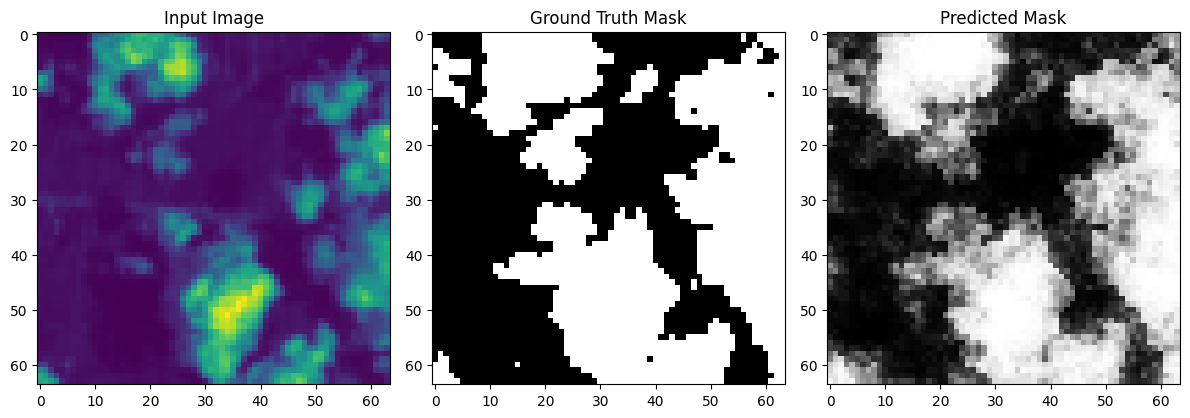

In [43]:
# Selecting a random index from the validation set
import random
import matplotlib.pyplot as plt
index = random.randint(0, len(images) - 1)

# Using the selected image for prediction
input_image = np.expand_dims(images[index], axis=0)  # Adding batch dimension
predicted_mask = model.predict(input_image)

# Plotting the original image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(images[index])
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(labels[index], cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.tight_layout()
plt.show()